# Week 5 Project

Jiwei Xia

In [16]:
# upload documents, run this only when using Google Colab
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()
uploaded3 = files.upload()
uploaded4 = files.upload()
uploaded5 = files.upload()

Saving DailyPrices.csv to DailyPrices (1).csv


Saving DailyReturn.csv to DailyReturn.csv


Saving portfolio.csv to portfolio (1).csv


Saving problem1.csv to problem1 (1).csv


Saving risklib.py to risklib (1).py


In [17]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
import pandas as pd
import risklib

## Problem 1

Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data.
Calculate the VaR and ES for both fitted distributions.

In [12]:
# Read in the data
data1 = np.genfromtxt('problem1.csv', delimiter=',')
data1 = np.delete(data1, 0, 0)

# Fit for normal distribution.
params_norm = norm.fit(data1)
mean, std = params_norm

# Fit for T distribution.
params_t = t.fit(data1)
df, loc, scale = params_t

# Generate simulation data
nsamples = 10000
norm_simulation = norm(mean, std).rvs(nsamples)
t_simulation = t(df, loc, scale).rvs(nsamples)

# Calculate VaR
var_norm = risklib.calculate_var(norm_simulation)
var_t = risklib.calculate_var(t_simulation)
print("Normal distribution VaR: " + str(var_norm))
print("T distribution VaR: " + str(var_t))
print()

# Calculate Expected Shortfall
es_norm = risklib.calculate_es(norm_simulation)
es_t = risklib.calculate_es(t_simulation)
print("Normal distribution ES: " + str(es_norm))
print("T distribution ES: " + str(es_t))

Normal distribution VaR: 0.08267218711386384
T distribution VaR: 0.07642875255222724

Normal distribution ES: 0.10335807374245087
T distribution ES: 0.11435293426049195


Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the
differences.

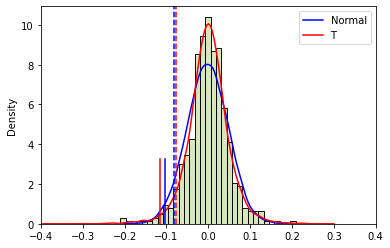

In [15]:
plt.figure()
norm_color = "b"
t_color = "r"

# plot histogram and 2 distributions PDFs
sns.histplot(data1, stat="density", color="#cadea5")
sns.kdeplot(norm_simulation, color=norm_color, label='Normal')
sns.kdeplot(t_simulation, color=t_color, label='T')

# overlay the VaR and ES on existing plot
plt.axvline(-var_norm, color=norm_color, linestyle='--')
plt.axvline(-var_t, color=t_color, linestyle='--')
plt.axvline(-es_norm, 0, 0.3, color=norm_color)
plt.axvline(-es_t, 0, 0.3, color=t_color)

plt.xlim(-0.4, 0.4)
plt.legend()

plt.show()

We can see that the T distribution could better describe the original data. With T distribution, the VaR is larger than normal distribution, while the ES is smaller than normal distribution.

## Problem 2

In your main repository, create a Library for risk management. Create modules, classes, packages, etc
as you see fit. Include all the functionality we have discussed so far in class. Make sure it includes
1. Covariance estimation techniques.
2. Non PSD fixes for correlation matrices
3. Simulation Methods
4. VaR calculation methods (all discussed)
5. ES calculation

Create a test suite and show that each function performs as expected.

In [26]:
# Test suite for each function

# Covariance estimation techniques
return_data = np.genfromtxt('DailyReturn.csv', delimiter=',').T
return_data = np.delete(return_data, 0, 0)
return_data = np.delete(return_data, 0, 1)
return_data = np.matrix(np.fliplr(return_data))

weights = risklib.calculate_exponential_weights(return_data.shape[1], lamb=0.97)
print(weights.shape)

ew_cov = risklib.calculate_ewcov(return_data, lamb=0.97)
print(ew_cov.shape)

(60,)
(101, 101)


In [25]:
# Non PSD fixes for correlation matrices
n = 500
sigma = np.matrix(np.full((n, n), 0.9))
np.fill_diagonal(sigma, 1)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

def is_psd(matrix, tol=1e-7):
   return np.all(np.linalg.eigvals(matrix) >= -tol)

near_psd_matrix = risklib.near_psd(sigma)
print(is_psd(near_psd_matrix))
higham_psd_matrix = risklib.higham_psd(sigma)
print(is_psd(higham_psd_matrix))

True
True


In [32]:
# Simulation Methods
res_d = risklib.direct_simulation(ew_cov)
res_pca = risklib.pca_simulation(ew_cov, pct_explained=0.75)
print(res_d.shape)
print(res_pca.shape)

(101, 25000)
(101, 25000)


In [57]:
# VaR calculation methods (all discussed)
sample_return = (return_data[0] - return_data[0].mean()).T
var_norm = risklib.normal_var(sample_return)
var_ew_norm = risklib.ewcov_normal_var(sample_return)
var_t = risklib.t_var(sample_return)
var_hist = risklib.historic_var(sample_return)
print(var_norm, var_ew_norm, var_t, var_hist)

0.014197334456905767 0.015286041372887598 0.013704767541548904 0.014594392883333331


In [59]:
# ES calculation
es = risklib.calculate_es(sample_return)
print(es)

0.020865585516666663


## Problem 3

Use your repository from #2.

Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0.

This file contains the stock holdings of 3 portfolios. You own each of these portfolios.

Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your
total VaR and ES. Compare the results from this to your VaR form Problem 3 from Week 4.

In [5]:
# load in data and calculate returns
prices = pd.read_csv("DailyPrices.csv", parse_dates=[0], index_col=0)
portfolios = pd.read_csv("portfolio.csv")
returns = risklib.pd_calculate_returns(prices)

# Combine the portfolios to get a total one and append it to the end for easier 
# calculation.
total_holdings = portfolios.groupby('Stock').sum('Holding')
total_holdings['Portfolio'] = 'Total'
total_holdings = total_holdings.reset_index()
portfolios = portfolios.append(total_holdings)

In [61]:
t_params = {}
hist_data = []
sim_data = []
for col in returns:
  stock_returns = returns[col]
  # we assume the expected return is 0
  stock_returns -= stock_returns.mean()
  hist_data.append(stock_returns)
  # fit a generalized t distribution to each stock
  result = t.fit(stock_returns, method="MLE")
  df, loc, scale = result
  t_params[col] = [df, loc, scale]
  # simulate based on t distribution for each stock
  sim_data.append(t(df, loc, scale).rvs(10000))
hist_data = np.array(hist_data)
sim_data = np.array(sim_data)

In [7]:
# create pandas dataframe for the returns
historical_returns = pd.DataFrame(columns=returns.columns, data=hist_data.T)
simulated_returns = pd.DataFrame(columns=returns.columns, data=sim_data.T)

In [8]:
# for historical data
current_prices = pd.DataFrame({"Price":prices.iloc[-1]})

for portfolio_index, portfolio in portfolios.groupby('Portfolio'):
  portfolio = portfolio.set_index('Stock')
  portfolio = portfolio.join(current_prices.loc[portfolio.index])

  hist_returns = historical_returns[portfolio.index]
  sim_prices_change = hist_returns * portfolio['Price'].T
  sim_values_change = sim_prices_change @ portfolio['Holding']

  historic_var = risklib.calculate_var(sim_values_change)
  historic_es = risklib.calculate_es(sim_values_change)
  print(f"Portfolio {portfolio_index} " + "VaR: " + str(historic_var))
  print(f"Portfolio {portfolio_index} " + "ES: " + str(historic_es))
  print()

Portfolio A VaR: 5588.637637386339
Portfolio A ES: 7882.311444624035

Portfolio B VaR: 5752.3140129135745
Portfolio B ES: 7403.569074819471

Portfolio C VaR: 3701.3634951367985
Portfolio C ES: 5262.46093351565

Portfolio Total VaR: 13406.884801649974
Portfolio Total ES: 20548.341452959157



In [9]:
# for simulated data based on t distribution
for portfolio_index, portfolio in portfolios.groupby('Portfolio'):
  portfolio = portfolio.set_index('Stock')
  portfolio = portfolio.join(current_prices.loc[portfolio.index])

  sim_returns = simulated_returns[portfolio.index]
  sim_prices_change = sim_returns * portfolio['Price'].T
  sim_values_change = sim_prices_change @ portfolio['Holding']

  sim_var = risklib.calculate_var(sim_values_change)
  sim_es = risklib.calculate_es(sim_values_change)
  print(f"Portfolio {portfolio_index} " + "VaR: " + str(sim_var))
  print(f"Portfolio {portfolio_index} " + "ES: " + str(sim_es))
  print()

Portfolio A VaR: 2090.6334455164624
Portfolio A ES: 2778.2296397540345

Portfolio B VaR: 1747.9413689698938
Portfolio B ES: 2447.7412507557246

Portfolio C VaR: 1582.5819970886935
Portfolio C ES: 2271.900125904539

Portfolio Total VaR: 3220.546245787668
Portfolio Total ES: 4444.138243475763



For the historical data, the result is very similar to the result in Problem 3 from Week 4. 

For the simulated data, since we fit a generalized T model and assume a T distribution, the result is different. Generally they are smaller than the result in Problem 3 from Week 4.